# SVM


In [1]:
import sys, os, re, gzip, json, pickle, shutil, random, joblib, math

import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
# paths
metadata_path = 'C:/Users/tianyi/Northeastern University/Machine Learning Final Project - Music Classification - Documents/myspace_mp3s/metadata.json.gz'
genre_map_path = 'C:/Users/tianyi/Northeastern University/Machine Learning Final Project - Music Classification - Documents/myspace_mp3s/genre_map.pkl'
mfcc_path = 'C:/Users/tianyi/Northeastern University/Machine Learning Final Project - Music Classification - Documents/audio_features/mfcc'


In [15]:
# choose two binary genres to use for binary classifier
binary_genres = ['metal', 'classical']
lab_idx = {g:i for i,g in enumerate(binary_genres)}
lab_idx

{'metal': 0, 'classical': 1}

In [16]:
# genre counts (# samples per genre)
genre_cts = {}
for genre in os.listdir(mfcc_path):
    genre_path = '%s/%s' % (mfcc_path, genre)
    if genre == 'desktop.ini':
        continue
    genre_cts[genre] = len(os.listdir(genre_path))
    
# number samples for genre that has min samples in binary list (out of metal and classical)
min_recs = min([genre_cts[g] for g in binary_genres])    

# print counts for each genre
for g in sorted(genre_cts, key=genre_cts.get, reverse=True):
    print(g, genre_cts[g])

rock 13158
metal 8782
alternative 8778
rap 5906
dance 5624
pop 4684
jazz 4552
hip_hop 4526
experimental 3686
other 3544
world 2225
electronic 2127
folk 1804
punk 1729
blues 1472
ambient 1299
reggae 1114
goth 722
acoustic 678
country 533
house 512
classical 486
spiritual 369
oldies 248
progressive 221
funk 142
easy_listening 131
spoken_word 130
bluegrass 48
industrial 44
showtunes 38
disco 23


In [17]:
# get list of all 32 final genres
genres = list(genre_cts.keys())
print(genres)

['acoustic', 'alternative', 'ambient', 'bluegrass', 'blues', 'classical', 'country', 'dance', 'disco', 'easy_listening', 'electronic', 'experimental', 'folk', 'funk', 'goth', 'hip_hop', 'house', 'industrial', 'jazz', 'metal', 'oldies', 'other', 'pop', 'progressive', 'punk', 'rap', 'reggae', 'rock', 'showtunes', 'spiritual', 'spoken_word', 'world']


In [18]:
# loading in the metadata and genre map
# metadata not used in this model; has original genres before mapping
with gzip.open(metadata_path, 'rt', encoding='utf-8') as fz:
    metadata = json.load(fz)

with open(genre_map_path, 'rb') as f:
    genre_map = pickle.load(f)
    
#example metadata
kys = list(metadata.keys())
ky=kys[0]
ky, metadata[ky]

('46/std_1f69563352d19cb0132334cd0d3adeaf.mp3',
 {'song_name': 'big_yellow_moon',
  'artist_name': 'bill_nelson',
  'mp3_zipname': '46',
  'mp3_filename': 'std_1f69563352d19cb0132334cd0d3adeaf.mp3',
  'genres': ['rock', 'electronica', 'alternative']})

In [19]:
def get_mfcc_lengths(mfcc_path, genres, max_recs):
    '''
        Gets the lengths of each mfcc file (one per song) across 
        each genre that we are working with. 
        
        mfcc_path: path to mfcc files (currently on OneDrive)
        genres: list of genres we are working with (coudl be binary or multi)
        max_recs: the genre that has the least number of samples
    '''
    
    widths=[] # holds the lens of each np array (for each song) --> columns
    heights = [] # rows
    
    for genre in genres:
        genre_path = '%s/%s' % (mfcc_path, genre) # get path to all song mfccs in current genre
        ct = 0
        file_errors = 0
        for fn in os.listdir(genre_path): # for each song mfcc (only do as many songs as min genre so classes are even)
            fp = '%s/%s' % (genre_path, fn) # path to mfcc
            try:
                mfcc = np.load(fp) # load the np file
                widths.append(mfcc.shape[1]) # get the number of columns in the np array
                heights.append(mfcc.shape[0]) # get heights of the np array
                ct+=1
            except:
                file_errors += 1
            if ct>=max_recs:
                break
            
    # files that aren't loaded by onedrive won't read in (should be 0)
    print('Missed files: ', file_errors)
    l = np.array(widths)
    h = np.array(heights)
    
    return l, h

Missed files:  0
Mean mfcc widths: 9853.0833, std: 4784.7813
Mean mfcc height: 20.0000, std: 0.0000



Width Histogram for Metal and Classical Genres


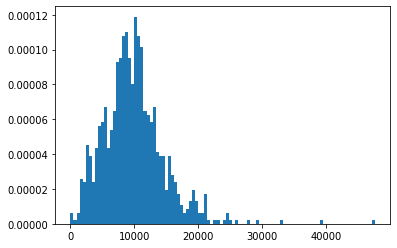

In [20]:
l, h = get_mfcc_lengths(mfcc_path, binary_genres, min_recs)

print('Mean mfcc widths: %.4f, std: %.4f' % (l.mean(), l.std())) #11098.8838, std: 4614.7522
print('Mean mfcc height: %.4f, std: %.4f' % (h.mean(), h.std())) #11098.8838, std: 4614.7522
print('\n\n')
print('Width Histogram for Metal and Classical Genres')
plt.hist(l, bins=100, density=True)
plt.show()

In [21]:
def shuffle_data(x, y):
    '''
    Shuffles x and y data. 
    '''
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    
    return x, y


def normalize_data(x):
    '''
    Normalizes x data. 
    '''
    return (x-x.mean())/x.std()


def get_mfccs(mfcc_path, genres, lab_idx, max_recs):
    '''
    Open and process mfcc and return as x and y arrays.
    '''
    
    # save all x and y values
    mfccs = []
    y=[]
    i = 0
    
    # loop over each genre we are working with
    for genre in genres:
        
        # extract path to all song mfccs in current genre
        genre_path = '%s/%s' % (mfcc_path, genre)
        ct = 0
        
        # loop over each mfcc in current genre
        for fn in os.listdir(genre_path): 
            
            i += 1
            # get path to mfcc
            fp = '%s/%s' % (genre_path, fn)
            
            # load mfcc and transpose/take mean
            mfcc = np.load(fp) 
            mfcc = np.mean(mfcc.T,axis=0)
            mfccs.append(mfcc)
            
            # append target label to list
            y.append(lab_idx[genre])
            
            # for creating balanced dataset
            ct+=1
            if ct>=max_recs: 
                break
           
    # normalize data and create arrays
    x = np.array(mfccs)
    x = normalize_data(x)
    y = np.array(y)
    
    return shuffle_data(x, y)

In [22]:
# 972 samples, 20 features per sample for Metal and Classical
x, y = get_mfccs(mfcc_path, binary_genres, lab_idx, min_recs)
x.shape, y.shape
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [23]:
print('training: ', x_train.shape, y_train.shape)
print('testing: ', x_test.shape, y_test.shape)

training:  (777, 20) (777,)
testing:  (195, 20) (195,)


In [24]:
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(x_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(x_train, y_train)
poly_pred = poly.predict(x_test)
rbf_pred = rbf.predict(x_test)


In [25]:
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  91.28
F1 (RBF Kernel):  91.25


In [26]:
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

Accuracy (Polynomial Kernel):  87.69
F1 (Polynomial Kernel):  87.53


# Multi-class